In [144]:
import json
import pickle
import numpy as np
import pandas as pd
import os.path as op
import itertools as it
from utilities import files
from mne import read_epochs
from functools import partial
import matplotlib.pylab as plt
from joblib import Parallel, delayed
from tqdm.notebook import trange, tqdm
from matplotlib.collections import LineCollection
from matplotlib import colors
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from skimage.measure import find_contours
from scipy.ndimage import gaussian_filter, gaussian_filter1d
from extra.tools import many_is_in, cat, shuffle_array, shuffle_array_range, consecutive_margin_ix, dump_the_dict
from mne.stats import permutation_cluster_1samp_test, spatio_temporal_cluster_test, permutation_cluster_test, ttest_1samp_no_p

In [145]:
visual_epoch_file = "/home/mszul/datasets/explicit_implicit_beta/derivatives/processed/sub-145/sub-145-002-visual-epo.fif"
motor_epoch_file = "/home/mszul/datasets/explicit_implicit_beta/derivatives/processed/sub-145/sub-145-002-motor-epo.fif"
burst_features_file = "/home/mszul/datasets/explicit_implicit_beta/derivatives/PCA_results/burst_features.csv"
waveform_array_file = "/home/mszul/datasets/explicit_implicit_beta/derivatives/PCA_results/all_waveforms.npy"
PC_burst_rate_spec_file = "/home/mszul/datasets/explicit_implicit_beta/derivatives/PCA_results/PC_burst_rate_spec.pkl"
burst_rate_overall_file = "/home/mszul/datasets/explicit_implicit_beta/derivatives/PCA_results/burst_rate_overall.pkl"    

In [3]:
visual_epoch = read_epochs(visual_epoch_file, verbose=False)
motor_epoch = read_epochs(motor_epoch_file, verbose=False)
visual_epoch_times = visual_epoch.times
motor_epoch_times = motor_epoch.times
del visual_epoch
del motor_epoch

In [146]:
buffer = 0.125
bin_width = 0.05
baseline_range = [-0.5, -0.25]


visual_time_bins = np.arange(visual_epoch_times[0] + buffer, visual_epoch_times[-1] - buffer, bin_width)
motor_time_bins = np.arange(motor_epoch_times[0] + buffer, motor_epoch_times[-1] - buffer, bin_width)

visual_bin_ranges = list(zip(visual_time_bins[:-1], visual_time_bins[1:]))
motor_bin_ranges = list(zip(motor_time_bins[:-1], motor_time_bins[1:]))
vis_time_plot = visual_time_bins[:-1]
mot_time_plot = motor_time_bins[:-1]



time_bins = {
    "vis": visual_time_bins,
    "mot": motor_time_bins
}

In [5]:
waveform_array = np.load(waveform_array_file)
burst_features = pd.read_csv(burst_features_file)

In [147]:
burst_rate_overall = pickle.load(open(burst_rate_overall_file, "rb"))

In [6]:
mean_waveform = np.mean(waveform_array, axis=0)

In [7]:
PC_to_analyse = ["PC_7", "PC_8", "PC_9", "PC_10"]

In [154]:
prct = np.linspace(0,100, num=5)
prct_ranges = list(zip(prct[:-1], prct[1:]))
all_PCs = ["PC_{}".format(i) for i in np.arange(1, 21)]
wvfrms = {
    k: [] for k in all_PCs
}

for pc_ix, pc_key in enumerate(all_PCs):
    for low, hi in prct_ranges:
        low_perc = np.percentile(burst_features[pc_key], low)
        hi_perc = np.percentile(burst_features[pc_key], hi)
        wvf_ixs = burst_features.loc[
            (burst_features[pc_key] >= low_perc) &
            (burst_features[pc_key] <= hi_perc) 
        ].index
        MWF = np.mean(waveform_array[wvf_ixs, :], axis=0)
        wvfrms[pc_key].append(MWF)

In [148]:
PC_burst_rate_spec = pickle.load(open(PC_burst_rate_spec_file, "rb"))

In [149]:
brate_mean_vis = np.mean(burst_rate_overall["vis"], axis=0)
brate_sem_vis = np.std(burst_rate_overall["vis"], axis=0) / np.sqrt(36)
brate_mean_mot = np.mean(burst_rate_overall["mot"], axis=0)
brate_sem_mot = np.std(burst_rate_overall["mot"], axis=0) / np.sqrt(36)

In [150]:
all_values = np.hstack([np.mean(PC_burst_rate_spec[pc][ep], axis=0).flatten() for ep in ["mot", "vis"] for pc in PC_burst_rate_spec.keys()])

In [158]:
# stats TFCE + "hat" variance adjustment + FWER https://doi.org/10.1016/j.neuroimage.2011.10.027
# https://mne.tools/stable/auto_tutorials/stats-sensor-space/10_background_stats.html#visualize-and-compare-methods
# Clustering with TFCE and "hat" variance adjustment narrows down the area declared significant
PC_sig_masks_file = "/home/mszul/datasets/explicit_implicit_beta/derivatives/PCA_results/PC_sig_masks.pkl"
if op.exists(PC_sig_masks_file):
    sig_masks = pickle.load(open(PC_sig_masks_file, "rb"))
else:
    threshold_tfce = dict(start=0, step=0.2)
    sigma = 1e-3
    hat_corr = partial(ttest_1samp_no_p, sigma=sigma)

    sig_masks = {} # PC_key: [vis, mot]

    for pc_ix, pc_key in enumerate(all_PCs):
        vis = np.array(all_PC_burst_rate_spec[pc_key]["vis"])
        vis_mean = np.mean(all_PC_burst_rate_spec[pc_key]["vis"], axis=0)
        mot = np.array(all_PC_burst_rate_spec[pc_key]["mot"])
        mot_mean = np.mean(all_PC_burst_rate_spec[pc_key]["mot"], axis=0)

        vis_T_HAT, _, vis_P_HAT, _ = permutation_cluster_1samp_test(
            vis, stat_fun=hat_corr,
            threshold = threshold_tfce, n_permutations=1000, n_jobs=10,
            out_type="mask", verbose=False, adjacency=None, buffer_size=None
        )

        vis_mask = np.reshape(vis_P_HAT, vis_mean.shape)
        vis_mask[vis_mask >= 0.05] = 1
        vis_mask[vis_mask < 0.05] = np.nan

        mot_T_HAT, _, mot_P_HAT, _ = permutation_cluster_1samp_test(
            mot, stat_fun=hat_corr,
            threshold = threshold_tfce, n_permutations=1000, n_jobs=10,
            out_type="mask", verbose=False, adjacency=None, buffer_size=None
        )

        mot_mask = np.reshape(mot_P_HAT, mot_mean.shape)
        mot_mask[mot_mask >= 0.05] = 1
        mot_mask[mot_mask < 0.05] = np.nan

        sig_masks[pc_key] = [vis_mask, mot_mask]
    pickle.dump(sig_masks, open(PC_sig_masks_file, "wb"))

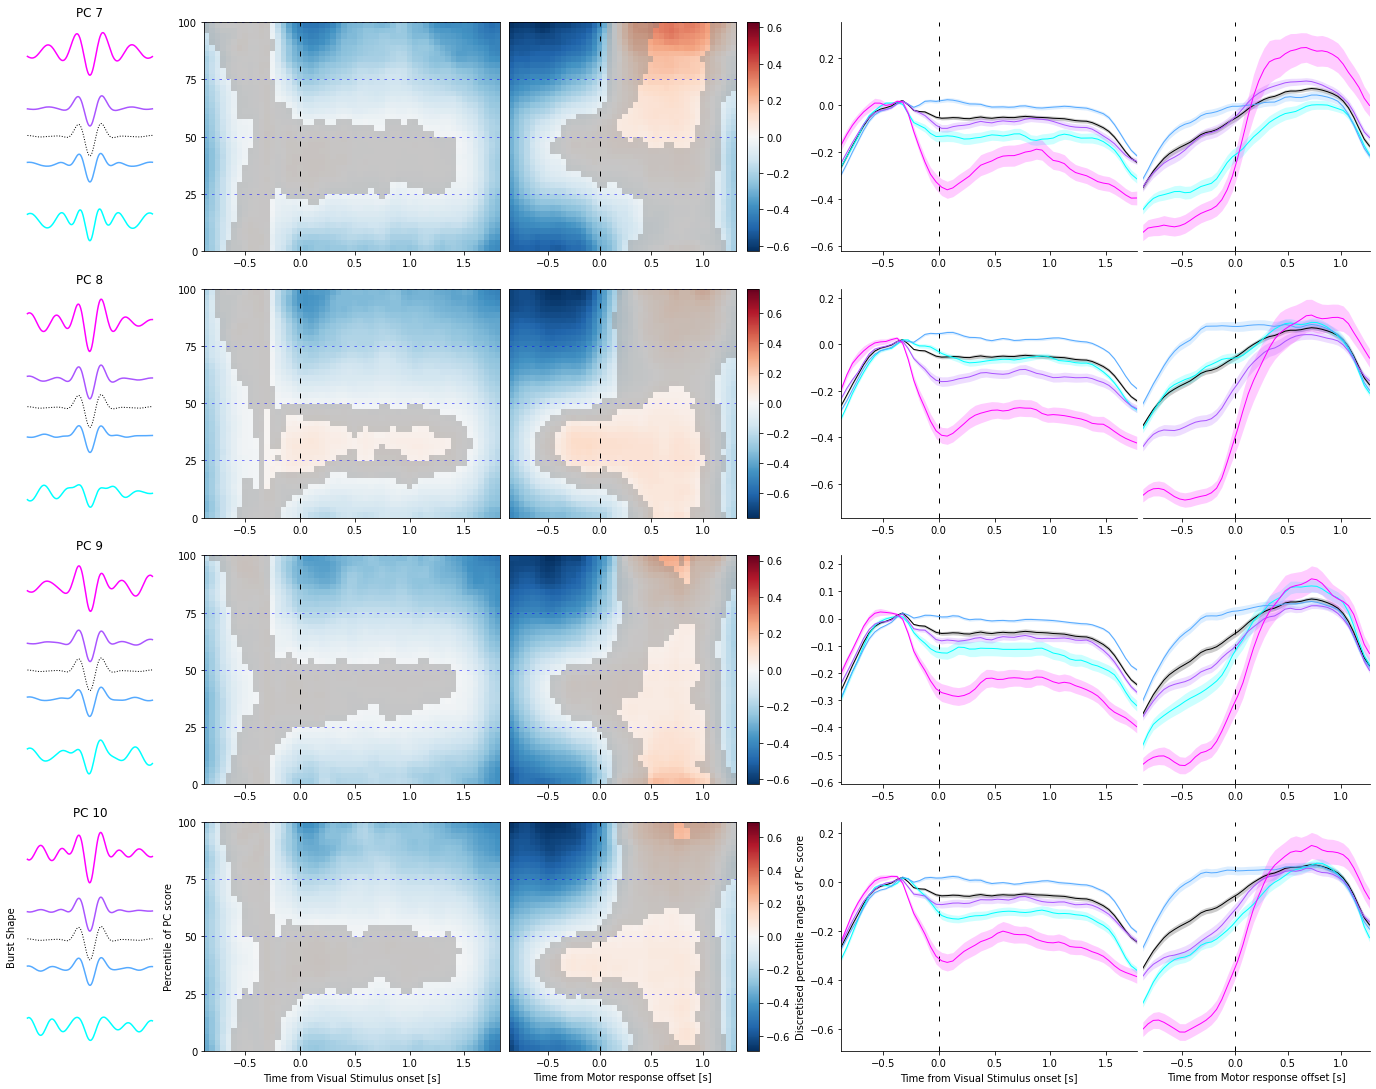

In [152]:
vis_xticks = [-0.5, 0, 0.5, 1, 1.5]
mot_xticks = [-0.5, 0, 0.5, 1]

score_prc_range = np.linspace(0, 100, 40)
waveform_time = np.linspace(-.13, .13, num=156)
col_r = plt.cm.cool(np.linspace(0,1, num=4))
graynorm = colors.TwoSlopeNorm(vmin=0, vcenter=1, vmax=1.1)

f, ax = plt.subplots(
    len(PC_to_analyse), 5, figsize=(19, len(PC_to_analyse)*3+3), 
    facecolor="white", gridspec_kw={'width_ratios': [1, 2.15, 1.65, 2.15, 1.65]},
    constrained_layout=True
)

for pc_ix, pc_key in enumerate(PC_to_analyse):  
    label = " ".join([i for i in pc_key.split("_")])
    ax[pc_ix, 0].set_title(label)
    for key, spine in ax[pc_ix, 0].spines.items():
        spine.set_visible(False)
    ax[pc_ix, 0].set_yticks([])
    ax[pc_ix, 0].set_xticks([])
    for pr in range(4):
        ax[pc_ix, 0].plot(waveform_time, wvfrms[pc_key][pr]*1e14 + np.mean([prct[pr], prct[pr+1]]), c=col_r[pr])
    ax[pc_ix, 0].plot(waveform_time, mean_waveform*1e14 + 50, c="black", lw=1, linestyle="dotted")
    
    max_abs = np.max([
        np.abs(np.mean(PC_burst_rate_spec[pc_key]["mot"], axis=0)).max(),
        np.abs(np.mean(PC_burst_rate_spec[pc_key]["vis"], axis=0)).max()
    ])
    
    divnorm = colors.TwoSlopeNorm(vmin=-max_abs, vcenter=0, vmax=max_abs)
    # BURSTxSCORE spectrum vis
    ax[pc_ix, 1].imshow(
        np.mean(PC_burst_rate_spec[pc_key]["vis"], axis=0).T,
        origin="lower", aspect="auto", norm=divnorm, cmap="RdBu_r",
        extent=[visual_time_bins[0], visual_time_bins[-1], 0, 100]
    )
    # BURSTxSCORE stat vis
    ax[pc_ix, 1].imshow(
        sig_masks[pc_key][0].T, origin="lower", aspect="auto",
        norm=graynorm, cmap="gray_r", alpha=0.4,
        extent=[visual_time_bins[0], visual_time_bins[-1], 0, 100]
    )
    ax[pc_ix, 1].set_xticks(vis_xticks)
    ax[pc_ix, 1].set_yticks(prct)
    
    for pr in prct:
        ax[pc_ix, 1].axhline(pr, lw=0.5, linestyle=(0, (5, 10)), c="blue")
    ax[pc_ix, 1].axvline(0, lw=1, linestyle=(0, (5, 10)), c="black")
    
    # BURSTxSCORE spectrum mot
    im_mot = ax[pc_ix, 2].imshow(
        np.mean(PC_burst_rate_spec[pc_key]["mot"], axis=0).T,
        origin="lower", aspect="auto", norm=divnorm, cmap="RdBu_r",
        extent=[motor_time_bins[0], motor_time_bins[-1], 0, 100]
    )
    # BURSTxSCORE stat mot
    ax[pc_ix, 2].imshow(
        sig_masks[pc_key][1].T, origin="lower", aspect="auto",
        norm=graynorm, cmap="gray_r", alpha=0.4,
        extent=[motor_time_bins[0], motor_time_bins[-1], 0, 100]
    )
    ax[pc_ix, 2].set_yticks([])
    ax[pc_ix, 2].set_xticks(mot_xticks)
    cbar = plt.colorbar(im_mot, ax=ax[pc_ix, 2])
    # cbar.set_label("Rate", rotation=90)
    for pr in prct:
        ax[pc_ix, 2].axhline(pr, lw=0.5, linestyle=(0, (5, 10)), c="blue")
    ax[pc_ix, 2].axvline(0, lw=1, linestyle=(0, (5, 10)), c="black")
    
    ax[pc_ix, 3].plot(vis_time_plot, brate_mean_vis, lw=1, color="black")
    ax[pc_ix, 3].fill_between(
        vis_time_plot, 
        brate_mean_vis - brate_sem_vis,
        brate_mean_vis + brate_sem_vis,
        lw=0, color="black", alpha=0.2
    )
    ax[pc_ix, 3].axvline(0, lw=1, linestyle=(0, (5, 10)), c="black")
    
    for c_ix, (b, e) in enumerate(prct_ranges):
        ixes = np.where(((score_prc_range) >= b) & (score_prc_range <= e))[0]
        selection = np.mean(np.array(PC_burst_rate_spec[pc_key]["vis"])[:,:, ixes], axis=2)
        mean = np.mean(selection, axis=0)
        sem = np.std(selection, axis=0) / np.sqrt(36)
        ax[pc_ix, 3].plot(vis_time_plot, mean, lw=1, color=col_r[c_ix])
        ax[pc_ix, 3].fill_between(
            vis_time_plot, 
            mean - sem,
            mean + sem,
            lw=0, color=col_r[c_ix], alpha=0.2
        )
    
    for key, spine in ax[pc_ix, 3].spines.items():
        if key in ["top", "right"]:
            spine.set_visible(False)
    
    ax[pc_ix, 4].plot(mot_time_plot, brate_mean_mot, lw=1, color="black")
    ax[pc_ix, 4].fill_between(
        mot_time_plot, 
        brate_mean_mot - brate_sem_mot,
        brate_mean_mot + brate_sem_mot,
        lw=0, color="black", alpha=0.2
    )
    ax[pc_ix, 4].axvline(0, lw=1, linestyle=(0, (5, 10)), c="black")
    
    for c_ix, (b, e) in enumerate(prct_ranges):
        ixes = np.where(((score_prc_range) >= b) & (score_prc_range <= e))[0]
        selection = np.mean(np.array(PC_burst_rate_spec[pc_key]["mot"])[:,:, ixes], axis=2)
        mean = np.mean(selection, axis=0)
        sem = np.std(selection, axis=0) / np.sqrt(36)
        ax[pc_ix, 4].plot(mot_time_plot, mean, lw=1, color=col_r[c_ix])
        ax[pc_ix, 4].fill_between(
            mot_time_plot, 
            mean - sem,
            mean + sem,
            lw=0, color=col_r[c_ix], alpha=0.2
        )
    
    ax[pc_ix, 4].set_yticks([])
    for key, spine in ax[pc_ix, 4].spines.items():
        if key in ["top", "left", "right"]:
            spine.set_visible(False)
    
    ymin = np.min([ax[pc_ix, 3].get_ylim()[0], ax[pc_ix, 4].get_ylim()[0]])
    ymax = np.max([ax[pc_ix, 3].get_ylim()[1], ax[pc_ix, 4].get_ylim()[1]])
    
    ax[pc_ix, 3].set_ylim(ymin, ymax)
    ax[pc_ix, 3].set_xlim(vis_time_plot[0], vis_time_plot[-1])
    ax[pc_ix, 4].set_ylim(ymin, ymax)
    ax[pc_ix, 4].set_xlim(mot_time_plot[0], mot_time_plot[-1])

ax[3, 0].set_ylabel("Burst Shape")
ax[3, 1].set_xlabel("Time from Visual Stimulus onset [s]")
ax[3, 1].set_ylabel("Percentile of PC score")
ax[3, 2].set_xlabel("Time from Motor response offset [s]")
ax[3, 3].set_xlabel("Time from Visual Stimulus onset [s]")
ax[3, 3].set_ylabel("Discretised percentile ranges of PC score")
ax[3, 4].set_xlabel("Time from Motor response offset [s]")

plt.savefig("/scratch/BURST_PAPER/FIGURE_5_PC_score_x_burst_rate.svg")

In [156]:
all_PC_burst_rate_spec_file = "/home/mszul/datasets/explicit_implicit_beta/derivatives/PCA_results/all_PC_burst_rate_spec.pkl"
if op.exists(all_PC_burst_rate_spec_file):
    all_PC_burst_rate_spec = pickle.load(open(all_PC_burst_rate_spec_file, "rb"))
all_PCs = ["PC_{}".format(i) for i in np.arange(1, 21)]


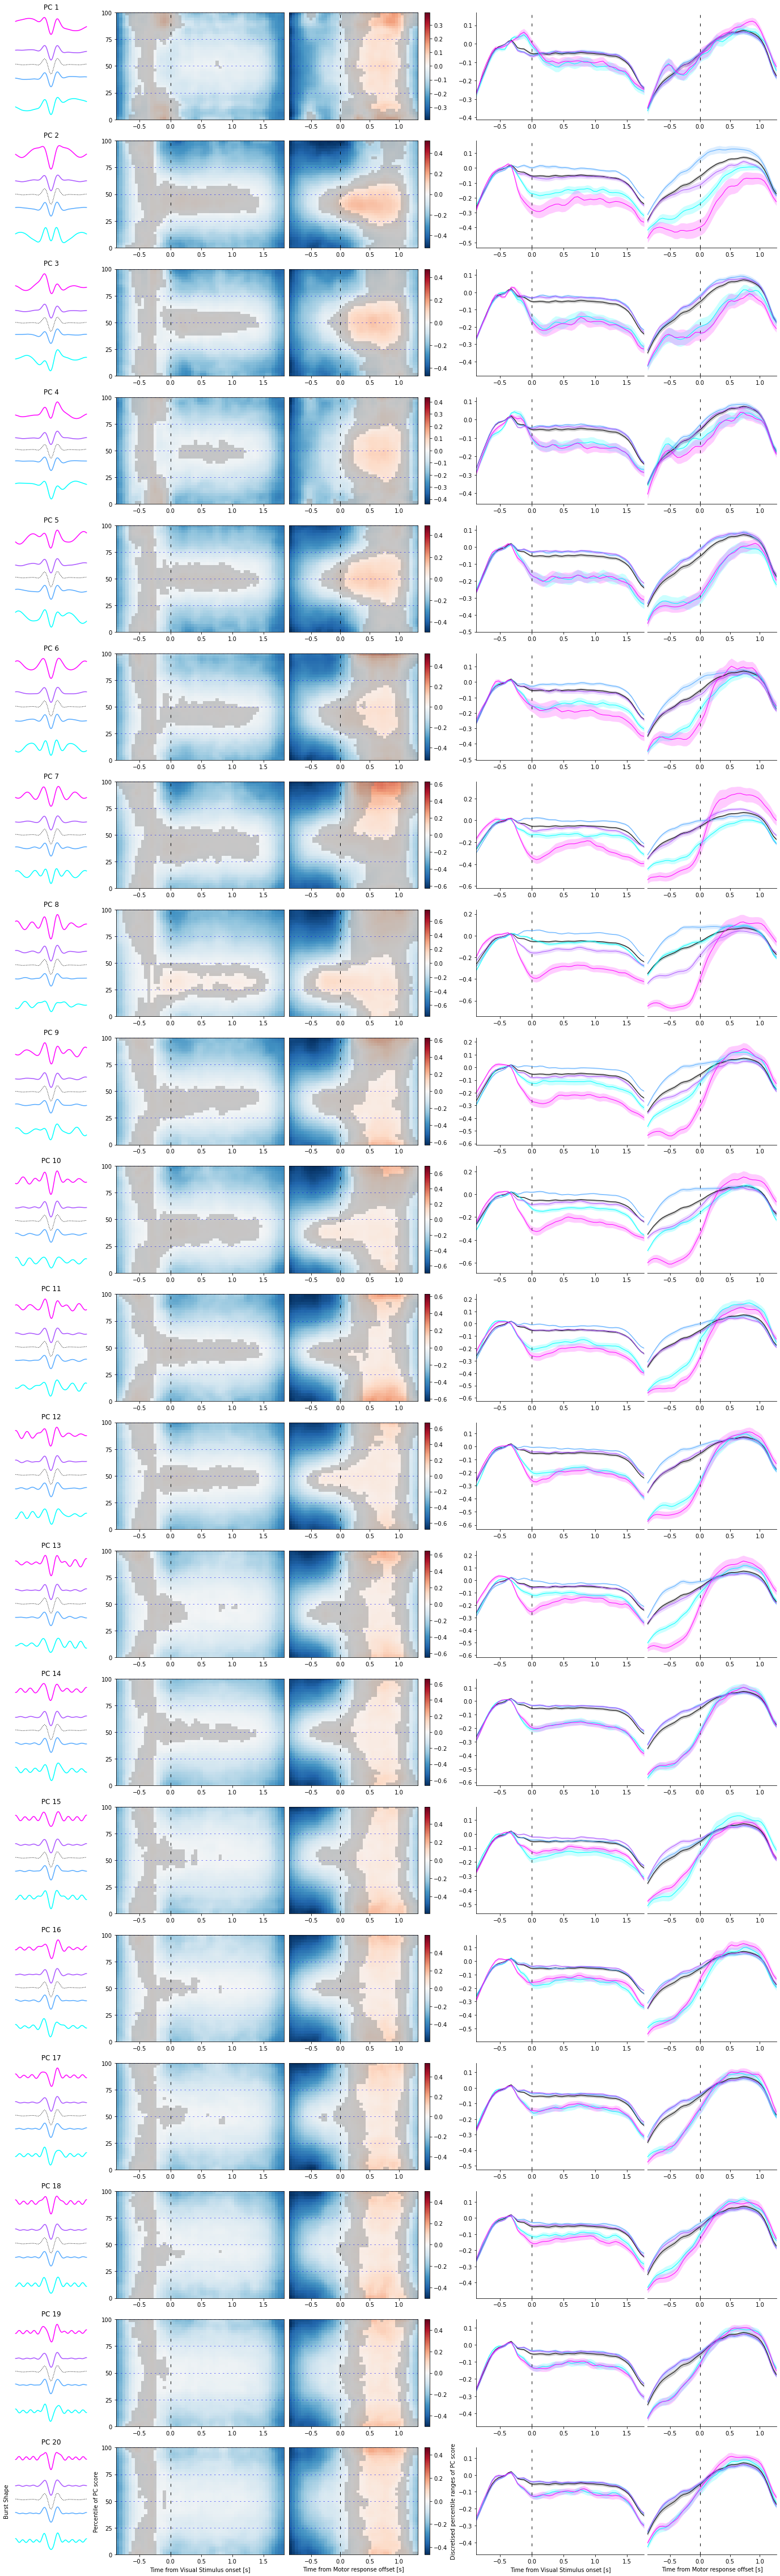

In [159]:
vis_xticks = [-0.5, 0, 0.5, 1, 1.5]
mot_xticks = [-0.5, 0, 0.5, 1]

score_prc_range = np.linspace(0, 100, 40)
waveform_time = np.linspace(-.13, .13, num=156)
col_r = plt.cm.cool(np.linspace(0,1, num=4))
graynorm = colors.TwoSlopeNorm(vmin=0, vcenter=1, vmax=1.1)

f, ax = plt.subplots(
    len(all_PCs), 5, figsize=(19, len(all_PCs)*3+3), 
    facecolor="white", gridspec_kw={'width_ratios': [1, 2.15, 1.65, 2.15, 1.65]},
    constrained_layout=True
)

for pc_ix, pc_key in enumerate(all_PCs):  
    label = " ".join([i for i in pc_key.split("_")])
    ax[pc_ix, 0].set_title(label)
    for key, spine in ax[pc_ix, 0].spines.items():
        spine.set_visible(False)
    ax[pc_ix, 0].set_yticks([])
    ax[pc_ix, 0].set_xticks([])
    for pr in range(4):
        ax[pc_ix, 0].plot(waveform_time, wvfrms[pc_key][pr]*1e14 + np.mean([prct[pr], prct[pr+1]]), c=col_r[pr])
    ax[pc_ix, 0].plot(waveform_time, mean_waveform*1e14 + 50, c="black", lw=1, linestyle="dotted")
    
    max_abs = np.max([
        np.abs(np.mean(all_PC_burst_rate_spec[pc_key]["mot"], axis=0)).max(),
        np.abs(np.mean(all_PC_burst_rate_spec[pc_key]["vis"], axis=0)).max()
    ])
    
    divnorm = colors.TwoSlopeNorm(vmin=-max_abs, vcenter=0, vmax=max_abs)
    # BURSTxSCORE spectrum vis
    ax[pc_ix, 1].imshow(
        np.mean(all_PC_burst_rate_spec[pc_key]["vis"], axis=0).T,
        origin="lower", aspect="auto", norm=divnorm, cmap="RdBu_r",
        extent=[visual_time_bins[0], visual_time_bins[-1], 0, 100]
    )
    # BURSTxSCORE stat vis
    ax[pc_ix, 1].imshow(
        sig_masks[pc_key][0].T, origin="lower", aspect="auto",
        norm=graynorm, cmap="gray_r", alpha=0.4,
        extent=[visual_time_bins[0], visual_time_bins[-1], 0, 100]
    )
    ax[pc_ix, 1].set_xticks(vis_xticks)
    ax[pc_ix, 1].set_yticks(prct)
    
    for pr in prct:
        ax[pc_ix, 1].axhline(pr, lw=0.5, linestyle=(0, (5, 10)), c="blue")
    ax[pc_ix, 1].axvline(0, lw=1, linestyle=(0, (5, 10)), c="black")
    
    # BURSTxSCORE spectrum mot
    im_mot = ax[pc_ix, 2].imshow(
        np.mean(all_PC_burst_rate_spec[pc_key]["mot"], axis=0).T,
        origin="lower", aspect="auto", norm=divnorm, cmap="RdBu_r",
        extent=[motor_time_bins[0], motor_time_bins[-1], 0, 100]
    )
    # BURSTxSCORE stat mot
    ax[pc_ix, 2].imshow(
        sig_masks[pc_key][1].T, origin="lower", aspect="auto",
        norm=graynorm, cmap="gray_r", alpha=0.4,
        extent=[motor_time_bins[0], motor_time_bins[-1], 0, 100]
    )
    ax[pc_ix, 2].set_yticks([])
    ax[pc_ix, 2].set_xticks(mot_xticks)
    cbar = plt.colorbar(im_mot, ax=ax[pc_ix, 2])
    # cbar.set_label("Rate", rotation=90)
    for pr in prct:
        ax[pc_ix, 2].axhline(pr, lw=0.5, linestyle=(0, (5, 10)), c="blue")
    ax[pc_ix, 2].axvline(0, lw=1, linestyle=(0, (5, 10)), c="black")
    
    ax[pc_ix, 3].plot(vis_time_plot, brate_mean_vis, lw=1, color="black")
    ax[pc_ix, 3].fill_between(
        vis_time_plot, 
        brate_mean_vis - brate_sem_vis,
        brate_mean_vis + brate_sem_vis,
        lw=0, color="black", alpha=0.2
    )
    ax[pc_ix, 3].axvline(0, lw=1, linestyle=(0, (5, 10)), c="black")
    
    for c_ix, (b, e) in enumerate(prct_ranges):
        ixes = np.where(((score_prc_range) >= b) & (score_prc_range <= e))[0]
        selection = np.mean(np.array(all_PC_burst_rate_spec[pc_key]["vis"])[:,:, ixes], axis=2)
        mean = np.mean(selection, axis=0)
        sem = np.std(selection, axis=0) / np.sqrt(36)
        ax[pc_ix, 3].plot(vis_time_plot, mean, lw=1, color=col_r[c_ix])
        ax[pc_ix, 3].fill_between(
            vis_time_plot, 
            mean - sem,
            mean + sem,
            lw=0, color=col_r[c_ix], alpha=0.2
        )
    
    for key, spine in ax[pc_ix, 3].spines.items():
        if key in ["top", "right"]:
            spine.set_visible(False)
    
    ax[pc_ix, 4].plot(mot_time_plot, brate_mean_mot, lw=1, color="black")
    ax[pc_ix, 4].fill_between(
        mot_time_plot, 
        brate_mean_mot - brate_sem_mot,
        brate_mean_mot + brate_sem_mot,
        lw=0, color="black", alpha=0.2
    )
    ax[pc_ix, 4].axvline(0, lw=1, linestyle=(0, (5, 10)), c="black")
    
    for c_ix, (b, e) in enumerate(prct_ranges):
        ixes = np.where(((score_prc_range) >= b) & (score_prc_range <= e))[0]
        selection = np.mean(np.array(all_PC_burst_rate_spec[pc_key]["mot"])[:,:, ixes], axis=2)
        mean = np.mean(selection, axis=0)
        sem = np.std(selection, axis=0) / np.sqrt(36)
        ax[pc_ix, 4].plot(mot_time_plot, mean, lw=1, color=col_r[c_ix])
        ax[pc_ix, 4].fill_between(
            mot_time_plot, 
            mean - sem,
            mean + sem,
            lw=0, color=col_r[c_ix], alpha=0.2
        )
    
    ax[pc_ix, 4].set_yticks([])
    for key, spine in ax[pc_ix, 4].spines.items():
        if key in ["top", "left", "right"]:
            spine.set_visible(False)
    
    ymin = np.min([ax[pc_ix, 3].get_ylim()[0], ax[pc_ix, 4].get_ylim()[0]])
    ymax = np.max([ax[pc_ix, 3].get_ylim()[1], ax[pc_ix, 4].get_ylim()[1]])
    
    ax[pc_ix, 3].set_ylim(ymin, ymax)
    ax[pc_ix, 3].set_xlim(vis_time_plot[0], vis_time_plot[-1])
    ax[pc_ix, 4].set_ylim(ymin, ymax)
    ax[pc_ix, 4].set_xlim(mot_time_plot[0], mot_time_plot[-1])

ax[19, 0].set_ylabel("Burst Shape")
ax[19, 1].set_xlabel("Time from Visual Stimulus onset [s]")
ax[19, 1].set_ylabel("Percentile of PC score")
ax[19, 2].set_xlabel("Time from Motor response offset [s]")
ax[19, 3].set_xlabel("Time from Visual Stimulus onset [s]")
ax[19, 3].set_ylabel("Discretised percentile ranges of PC score")
ax[19, 4].set_xlabel("Time from Motor response offset [s]")

plt.savefig("/scratch/BURST_PAPER/supplementary_PC_score_x_burst_rate.svg")